# The Keras Functional API

> In this post, it will introduce the Funtional API as an alternative way of building the planning model in Tensorflow. This is the summary of lecture "Customizing your model with Tensorflow 2" from Coursera.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Deep_Learning, Tensorflow]
- image: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

plt.rcParams['figure.figsize'] = (16, 10)

print(tf.__version__)

2.3.1


## The Keras functional API

The reason you might want to use is if you need more flexibility in the type of model you want to build. For example, perhaps your model has multiple inputs and outputs because you're training and multitask learning model, or maybe you're using conditioning variables, or perhaps it has some complicated nonlinear topology with the layers feeding into multiple other layers in the network, something like a residual network or a DenseNet, for example. These are types of networks that can't be built in the simple linear fashion offered by the Sequential API. But the Functional API, makes it easy to build those types of networks. 

### Example of Sequential API
```python
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, AveragePooling1D

model = Sequential([
    Conv1D(16, 5, activation='relu', input_shape=(32, 1)),
    AveragePooling1D(3),
    Flatten(),
    Dense(20, activation='sigmoid')
])
```

### Example of Functional API

```python
from tensorflow.keras.layers import Input, Dense, Flatten, Conv1D, AveragePooling1D
from tensorflow.keras.models import Model

inputs = Input(shape=(32, 1))
h = Conv1D(16, 5, activation='relu')(inputs)
h = AveragePooling1D(3)(h)
h = Flatten()(h)
outputs = Dense(20, activation='sigmoid')(h)

model = Model(inputs=inputs, outputs=outputs)
```

The difference between them is how we build the model.

## Multiple inputs and outputs

The key point is that we instantiate the layers that we want in the same way as we do for the sequential model. But we then use those layer objects as functions that call on an input tensor and return a layer output tensor.

### Multiple inputs Example

```python
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv1D, AveragePooling1D, Concatenate

inputs = Inputs(shape=(32, 1))
h = Conv1D(16, 5, activation='relu')(inputs)
h = AveragePooling1D(3)(h)
h = Flatten()(h)
aux_inputs = Input(shape=(12, 1))
h = Concatenate()([h, aux_inputs])
outputs = Dense(20, activation='sigmoid')(h)

model = Model(inputs=[inputs, aux_inputs], outputs=outputs)
```

### Multiple outputs Example

```python
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv1D, AveragePooling1D, Concatenate

inputs = Inputs(shape=(32, 1))
h = Conv1D(16, 5, activation='relu')(inputs)
h = AveragePooling1D(3)(h)
h = Flatten()(h)
aux_inputs = Input(shape=(12, 1))
h = Concatenate()([h, aux_inputs])
outputs = Dense(20, activation='sigmoid')(h)
aux_outputs = Dense(1, activation='linear')(h)

model = Model(inputs=[inputs, aux_inputs], outputs=[outputs, aux_outputs])
```

When we use multiple inputs and outputs, we need to look carefully when we compile and fit the model

```python
model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1, 0.4], metrics=['accuracy'])
history = model.fit([X_train, X_aux], [y_train, y_aux], validation_split=0.2, epochs=20)
```

In this case, loss will be

$$ 1 \times \text{binary_crossentropy loss} + 0.4 \times \text{mse loss} $$

Or we can change the compile and fit function like this,

```python
model.compile(loss={'outputs': 'binary_crossentropy', 'aux_outputs': 'mse'}, 
              loss_weights{'outputs':1, 'aux_outputs': 0.4}, metrics=['accuracy'])
history = model.fit({'inputs': X_train, 'aux_inputs': X_aux},
                    {'outputs':y_train, 'aux_outputs': y_aux},
                     validation_split=0.2, epochs=20)
```

### Multiple inputs and outputs - Coding Tutorial

#### Load the acute inflammations dataset

The `acute inflammations` was created by a medical expert as a data set to test the expert system, which will perform the presumptive diagnosis of two diseases of the urinary system. You can find out more about the dataset [here](https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations).

Attribute information:

Inputs:
- Temperature of patient : 35C-42C
- Occurrence of nausea : yes/no
- Lumbar pain : yes/no
- Urine pushing (continuous need for urination) : yes/no
- Micturition pains : yes/no
- Burning of urethra, itch, swelling of urethra outlet : yes/no

Outputs:
- decision 1: Inflammation of urinary bladder : yes/no
- decision 2: Nephritis of renal pelvis origin : yes/no

#### Load the data

In [2]:
df = pd.read_csv('./dataset/diagnosis.csv')
df.head()
dataset = df.values

In [3]:
# Build train and test data split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset[:, :6], dataset[:, 6:], test_size=0.33)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(80, 6) (40, 6)
(80, 2) (40, 2)


In [4]:
## Assign training and testing inputs/outputs
temp_train, nocc_train, lumbp_train, up_train, mict_train, bis_train = np.transpose(X_train)
temp_test, nocc_test, lumbp_test, up_test, mict_test, bis_test = np.transpose(X_test)

inflam_train, nephr_train = y_train[:, 0], y_train[:, 1]
inflam_test, nephr_test = y_test[:, 0], y_test[:, 1]

In [5]:
temp_train

array([41.1, 40. , 40.4, 37. , 37. , 41.5, 40.2, 36. , 37.9, 36.6, 38. ,
       37.7, 40. , 40.6, 40.5, 40.4, 40. , 36.6, 40.7, 39.4, 36.8, 37.3,
       40. , 37.6, 37.5, 37.5, 36.8, 41.4, 36.6, 37.7, 41.5, 41.5, 39.7,
       40.6, 37.3, 40.4, 37.9, 37.1, 36. , 36.3, 40. , 41.2, 38.7, 37.7,
       40.7, 41.1, 37.1, 36. , 41. , 40.7, 37.9, 38.1, 37.2, 37.5, 38.3,
       35.5, 41. , 37. , 37.8, 36.7, 40.8, 36.9, 37.4, 37. , 40.4, 38.5,
       40. , 37.5, 40.4, 41. , 37.4, 41.2, 41.2, 37.1, 40. , 36.7, 36.2,
       40.7, 37. , 36.9])

#### Build the model

In [6]:
from tensorflow.keras import Input

shape_inputs = (1, )
temperature = Input(shape=shape_inputs, name='temp')
nausea_occurence = Input(shape=shape_inputs, name='nocc')
lumbar_pain = Input(shape=shape_inputs, name='lumbp')
urine_pushing = Input(shape=shape_inputs, name='up')
micturition_pains = Input(shape=shape_inputs, name='mict')
bis = Input(shape=shape_inputs, name='bis')

list_inputs = [temperature, nausea_occurence, lumbar_pain, urine_pushing, micturition_pains, bis]

In [7]:
from tensorflow.keras.layers import concatenate

# Merge all input features into a single large vector
x = concatenate(list_inputs)

In [8]:
from tensorflow.keras.layers import Dense

# Use logistic regression classifier for disease prediction
inflammation_pred = Dense(1, activation='sigmoid', name='inflam')(x)
nephritis_pred = Dense(1, activation='sigmoid', name='nephr')(x)

In [9]:
# Create a list of all the outputs
list_outputs = [inflammation_pred, nephritis_pred]

In [10]:
from tensorflow.keras.models import Model

# Create the model object
model = Model(inputs=list_inputs, outputs=list_outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
temp (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
nocc (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
lumbp (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
up (InputLayer)                 [(None, 1)]          0                                            
_______________________________________________________________________________________

#### Plot the model

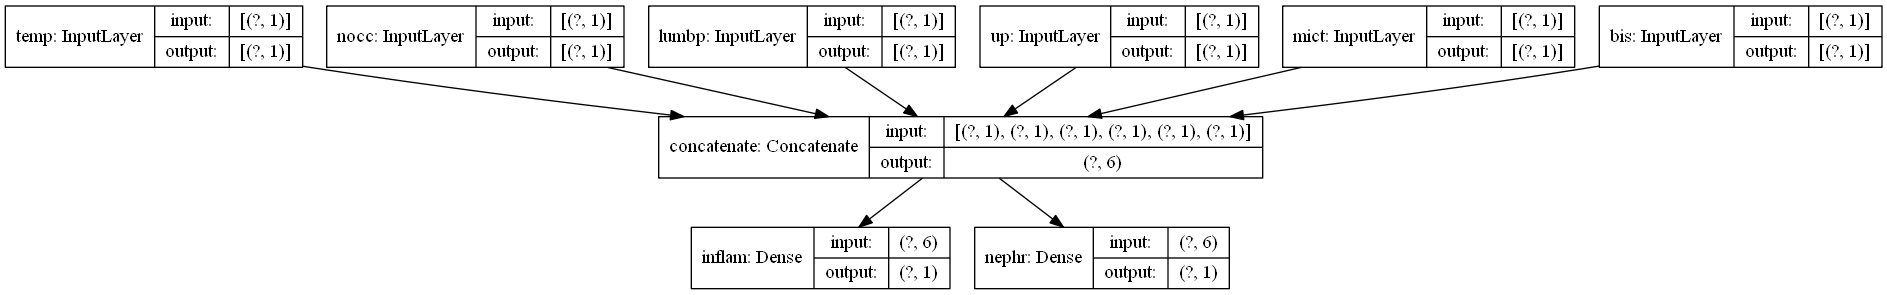

In [15]:
from tensorflow.keras.utils import plot_model

plot_model(model, 'multi_input_output_model.png', show_shapes=True)

#### Compile the model

In [16]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-3),
              loss={'inflam': 'binary_crossentropy', 
                    'nephr': 'binary_crossentropy'},
              metrics={
                  'inflam': ['accuracy'],
                  'nephr': ['accuracy']
              },
              loss_weights={
                  'inflam': 1.,
                  'nephr': 0.2
              })

#### Fit the model

In [17]:
# Define training inputs and ouptuts
inputs_train = {'temp': temp_train, 'nocc': nocc_train, 'lumbp': lumbp_train,
                'up': up_train, 'mict': mict_train, 'bis': bis_train}

outputs_train = {'inflam': inflam_train, 'nephr': nephr_train}

In [18]:
# Train the model
history = model.fit(inputs_train, outputs_train,
                    epochs=1000,
                    batch_size=128,
                    verbose=False)

#### Plot the learning curves

In [19]:
acc_keys = [k for k in history.history.keys() if k in ('inflam_accuracy', 'nephr_accuracy')]
loss_keys = [k for k in history.history.keys() if not k in acc_keys]

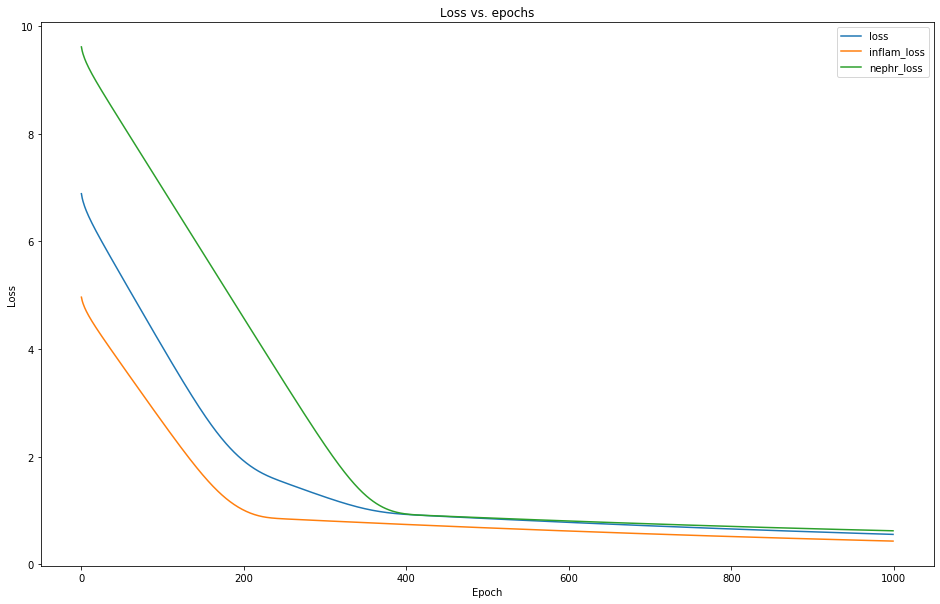

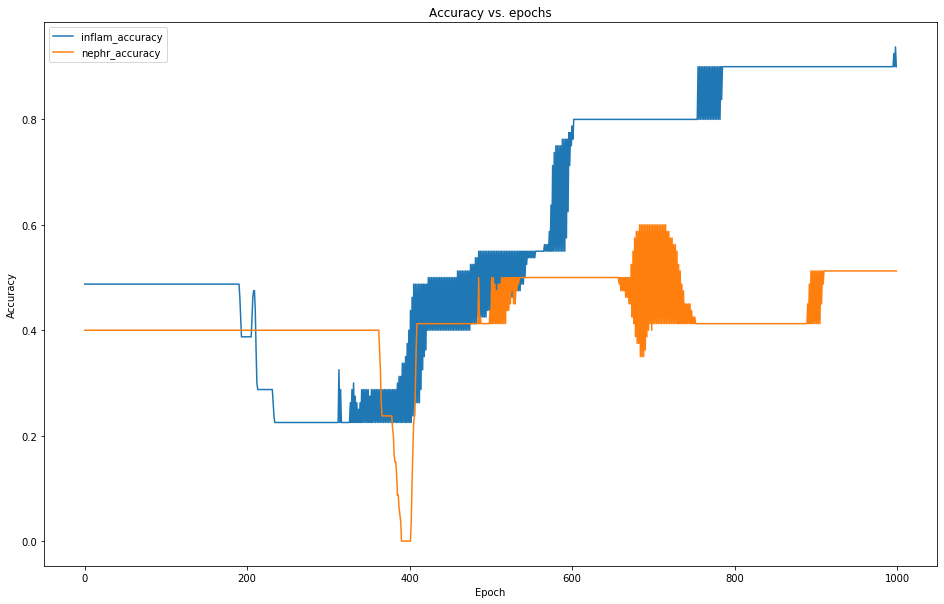

In [20]:
for k, v in history.history.items():
    if k in acc_keys:
        plt.figure(1)
        plt.plot(v)
    else:
        plt.figure(2)
        plt.plot(v)
        
plt.figure(1)
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(acc_keys, loc='best')

plt.figure(2)
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loss_keys, loc='best')
plt.show()

In [21]:
# Evaluate the model

model.evaluate([temp_test, nocc_test, lumbp_test, up_test, mict_test, bis_test], 
               [inflam_test, nephr_test], verbose=2)

2/2 - 0s - loss: 0.5562 - inflam_loss: 0.4258 - nephr_loss: 0.6520 - inflam_accuracy: 1.0000 - nephr_accuracy: 0.4500


[0.5562416315078735,
 0.42584753036499023,
 0.651970386505127,
 1.0,
 0.44999998807907104]

## Variables

An important point about tensorflow variablesis that they persist throughout your program, but they contain values that can be changed over the course of your program. Usually, we'll be using
variables as part of our models, and when we call `model.fit` to launch the training run, this will change the variable values for us as part of the optimization, but we can also change the variable values manually. Every variable has an assigned method, and we can just pass this method a new value for the
variable to store. Notice that the new value on assigning needs to be the right shape for the variable.

```python
import tensorflow as tf

my_var = tf.Variable([-1, 2], dtype=tf.float32, name='my_var')
my_var.assign([3.5, -1.])
```

## Tensors

Tensors - Multidimensional versions of vectors and arrays

When we build that neural network models, what we're doing is defining a computational graph
where input data is processed through the layers of the network and sent through the graph
all the way to the outputs. Tensors of the object that gets passed around within the graph and capture those computations within the graph.

### Example 1

In [22]:
# Example
# Simple computation graph
my_var = tf.Variable([-1, 2], dtype=tf.float32, name='my_var')
h = my_var + [5, 4]

print(h)

tf.Tensor([4. 6.], shape=(2,), dtype=float32)


### Example 2

In [23]:
from tensorflow.keras.layers import Dense, Input

inputs = Input(shape=(5, ))
h = Dense(16, activation='relu')(inputs)

print(h)

Tensor("dense/Relu:0", shape=(None, 16), dtype=float32)


In [24]:
inputs = Input(shape=(5, ))
h = Dense(16, activation='sigmoid')(inputs)
outputs = Dense(10, activation='softmax')(h)

model = Model(inputs=inputs, outputs=outputs)

print(model.input)
print(model.output)

Tensor("input_2:0", shape=(None, 5), dtype=float32)
Tensor("dense_2/Softmax:0", shape=(None, 10), dtype=float32)


## Variables and Tensors - Coding Tutorial

### Create variable objects

In [25]:
strings = tf.Variable(['Hello world!'], dtype=tf.string)
floats = tf.Variable([3.14159, 2.71828], dtype=tf.float32)
ints = tf.Variable([1, 2, 3], dtype=tf.int32)
complexs = tf.Variable([25.9 - 7.39j, 1.23 - 4.91j], tf.complex128)

In [26]:
# Initialize a Variable value
tf.Variable(tf.constant(4.2, shape=(3, 3)))

<tf.Variable 'Variable:0' shape=(3, 3) dtype=float32, numpy=
array([[4.2, 4.2, 4.2],
       [4.2, 4.2, 4.2],
       [4.2, 4.2, 4.2]], dtype=float32)>

### Use and modify variable values

In [27]:
v = tf.Variable(0.0)
w = v + 1

print(type(w))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [28]:
# Increment the value of a variable
v.assign_add(1)
print(v)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>


In [29]:
# Decrement the value of a variable
v.assign_sub(1)
print(v)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>


### Create Tensor objects

Create a constant tensor and print its type as well as its shape

In [30]:
x = tf.constant([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(x)
print('dtype: ', x.dtype)
print('shape: ', x.shape)

tf.Tensor(
[[1 2 3]
 [4 5 6]
 [7 8 9]], shape=(3, 3), dtype=int32)
dtype:  <dtype: 'int32'>
shape:  (3, 3)


In [31]:
# Obtain the value as a numpy array
x.numpy()

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [32]:
# Create a tensor of type float32
x = tf.constant([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=tf.float32)
print(x.dtype)

<dtype: 'float32'>


In [33]:
# Create coefficients
coeffs = np.arange(16)

In [34]:
# Initialize shapes
shape1 = [8, 2]
shape2 = [4, 4]
shape3 = [2, 2, 2, 2]

In [35]:
# Create tensors of different shape
a = tf.constant(coeffs, shape=shape1)
print('\n a:\n ', a)

b = tf.constant(coeffs, shape=shape2)
print('\n b:\n ', b)

c = tf.constant(coeffs, shape=shape3)
print('\n c:\n ', c)


 a:
  tf.Tensor(
[[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]], shape=(8, 2), dtype=int32)

 b:
  tf.Tensor(
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]], shape=(4, 4), dtype=int32)

 c:
  tf.Tensor(
[[[[ 0  1]
   [ 2  3]]

  [[ 4  5]
   [ 6  7]]]


 [[[ 8  9]
   [10 11]]

  [[12 13]
   [14 15]]]], shape=(2, 2, 2, 2), dtype=int32)


### Useful Tensor operations

In [36]:
# Create a constant tensor
t = tf.constant(np.arange(80), shape=[5, 2, 8])

In [37]:
# Get the rank of a Tensor
rank = tf.rank(t)

In [38]:
# Display the rank
print('rank :', rank)

rank : tf.Tensor(3, shape=(), dtype=int32)


In [39]:
# Reshape a Tensor
t2 = tf.reshape(t, [8, 10])

In [40]:
# Display the new shape
print('t2.shape: ', t2.shape)

t2.shape:  (8, 10)


In [41]:
# Create ones, zeros, identity and constant tensors
ones = tf.ones(shape=(2, 3))
zeros = tf.zeros(shape=(2, 4))
eye = tf.eye(3)
tensor7 = tf.constant(7.0, shape=[2, 2])

In [42]:
print("\n Ones:\n", ones)
print("\n Zeros:\n", zeros)
print("\n Identity:\n", eye)
print("\n Tensor filled with 7: ", tensor7)


 Ones:
 tf.Tensor(
[[1. 1. 1.]
 [1. 1. 1.]], shape=(2, 3), dtype=float32)

 Zeros:
 tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]], shape=(2, 4), dtype=float32)

 Identity:
 tf.Tensor(
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]], shape=(3, 3), dtype=float32)

 Tensor filled with 7:  tf.Tensor(
[[7. 7.]
 [7. 7.]], shape=(2, 2), dtype=float32)


In [43]:
# Create a ones tensor and a zeros tensor
t1 = tf.ones(shape=(2, 2))
t2 = tf.zeros(shape=(2, 2))

In [44]:
# Concatenate two tensors
concat0 = tf.concat([t1, t2], 0)
concat1 = tf.concat([t1, t2], 1)

In [45]:
print(concat0)
print(concat1)

tf.Tensor(
[[1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]], shape=(4, 2), dtype=float32)
tf.Tensor(
[[1. 1. 0. 0.]
 [1. 1. 0. 0.]], shape=(2, 4), dtype=float32)


In [46]:
# Create a constant tensor
t = tf.constant(np.arange(24), shape=(3, 2, 4))
print("\n t shape: ", t.shape)


 t shape:  (3, 2, 4)


In [47]:
# Expanding the rank of tensors
t1 = tf.expand_dims(t, 0)
t2 = tf.expand_dims(t, 1)
t3 = tf.expand_dims(t, 3)

In [48]:
# Display the shapes after tf.expand_dims
print("\n After expanding dims: \n t1 shape: ", t1.shape, 
      "\n t2 shape: ", t2.shape, 
      "\n t3 shape: ", t3.shape)


 After expanding dims: 
 t1 shape:  (1, 3, 2, 4) 
 t2 shape:  (3, 1, 2, 4) 
 t3 shape:  (3, 2, 4, 1)


In [49]:
# Squeezing redundant dimensions
t1 = tf.squeeze(t1, 0)
t2 = tf.squeeze(t2, 1)
t3 = tf.squeeze(t3, 3)

print("\n After Squeezing:\n t1 shape: ", t1.shape,
      "\n t2 shape: ", t2.shape,
      "\n t3 shape: ", t3.shape)


 After Squeezing:
 t1 shape:  (3, 2, 4) 
 t2 shape:  (3, 2, 4) 
 t3 shape:  (3, 2, 4)


In [50]:
# Slicing a tensor
x = tf.constant([1, 2, 3, 4, 5, 6, 7])
print(x[1:4])

tf.Tensor([2 3 4], shape=(3,), dtype=int32)


### Doing maths with Tensors

In [51]:
# Create two constant Tensors
c = tf.constant([[1.0, 2.0], [3.0, 4.0]])
d = tf.constant([[1.0, 1.0], [0.0, 1.0]])

In [52]:
# Matrix multiplication
matmul_cd = tf.matmul(c, d)

# Display the result
print("tf.matmul(c, d): \n", matmul_cd)

tf.matmul(c, d): 
 tf.Tensor(
[[1. 3.]
 [3. 7.]], shape=(2, 2), dtype=float32)


In [53]:
# Elementwise operations
c_times_d = c * d
c_plus_d = c + d
c_minus_d = c - d
c_div_c = c / c

print("c * d: \n", c_times_d)
print("c + d: \n", c_plus_d)
print("c - d: \n", c_minus_d)
print("c / c: \n", c_div_c)

c * d: 
 tf.Tensor(
[[1. 2.]
 [0. 4.]], shape=(2, 2), dtype=float32)
c + d: 
 tf.Tensor(
[[2. 3.]
 [3. 5.]], shape=(2, 2), dtype=float32)
c - d: 
 tf.Tensor(
[[0. 1.]
 [3. 3.]], shape=(2, 2), dtype=float32)
c / c: 
 tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


In [54]:
# Create tensors
a = tf.constant([[2, 3], [3, 3]])
b = tf.constant([[8, 7], [2, 3]])
x = tf.constant([[-6.89 + 1.78j], [-2.54 + 2.15j]])

In [55]:
# Absolute value of a Tensor
absx = tf.abs(x)

In [56]:
# Power of a tensor
powaa = tf.pow(a, a)

In [57]:
# Display the result
print(absx)
print(powaa)

tf.Tensor(
[[7.11621388]
 [3.32777704]], shape=(2, 1), dtype=float64)
tf.Tensor(
[[ 4 27]
 [27 27]], shape=(2, 2), dtype=int32)


### Randomly sampled constant tensors

In [58]:
# Normal distribution
tn = tf.random.normal(shape=(2, 2), mean=0, stddev=1.)

In [60]:
# Uniform distribution
tu = tf.random.uniform(shape=(2, 1), minval=0, maxval=10, dtype='int32')

In [61]:
# Poisson Distribution
tp = tf.random.poisson(shape=(2, 2), lam=5)

In [62]:
# More math operations
d = tf.square(tn)
e = tf.exp(d)
f = tf.cos(c)